# Attention Prediction in a non-calibrated system

The purpose of this notebook is to predict a user's attention, meaning a model to decide whether a user is looking on the laptop's screen or not.  We want to achieve this without calibrating the system and by only using 2D frames from the laptop camera in real-time. 

For the thesis, we have created a dataset with labelled frames(1: looking, 0: not looking) and performed a couple of preprocessing steps to extract 68 facial landmarks on the face and the 2 iris points calculated by Loceye's eye-tracking algorithms. 
Below, we will try out different data architectures and classifiers to figure out the best performance.
To achieve real-time performance and non-biased behaviour, we do not want to include any calibrating process. Therefore we will approximate a mapping between the 2D camera points and the 3D world by solving the [Perspective-n-Point](https://en.wikipedia.org/wiki/Perspective-n-Point) problem using the built-in OpenCV method solvePnP. This way, we will obtain the Rotation and Translation matrix(3x1 each) for each frame. Afterwards, we will use them in different architectures to train a machine learning model that will predict the final output. The architectures presented below are:

 - Feed the raw two vectors in a classifier.
 - Feed the two vectors and the 2 iris points.

### Import packages

In [1]:
import numpy as np
import cv2
import dlib
from imutils import face_utils
import glob
import pickle
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
import json
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
from PIL import Image


# Custom Imports
from common_functions import get_camera_parameters,get_full_image_points,get_full_model_points,eye_aspect_ratio

### Load Dataset

In [3]:
# Load the dataset
with open('data_cleaned.json') as json_file:
    data_all = json.load(json_file)

DATASET_SIZE = len(data_all)
DEBUG = True
    
# Extract the keys in sorted order
keys = sorted(data_all)

# Convert python list to np array
keys = np.asarray(keys)

Function that returns the required parameters of the solvePnP method. The paramaters *model_points* and *dist_coeffs* are the same for every example so they are declared globally.

Debugging function used to visualize image points.

In [4]:
def visualize_image(im, rotation_vector, translation_vector, camera_matrix, image_points):
    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose
    (nose_end_point2D, jacobian) = cv2.projectPoints(
        np.array([(0.55592, 6.5629, 300.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs
        )
    for p in image_points:
        cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)
    cv2.circle(im, (int(iris_left[0]), int(iris_left[1])), 3, (0, 0, 255), -1)
    cv2.circle(im, (int(iris_right[0]), int(iris_right[1])), 3, (0, 0, 255), -1)

    # Draw a line connecting the two points. This line must show
    # the direction out of the nose
    p1 = ( int(image_points[33][0]), int(image_points[33][1]) )
    p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]) )
    cv2.line(im, p1, p2, (255,0,0), 2)
    
    # Display image
    cv2.imshow("Output", im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print("Rotation Vector:\n {0}".format(rotation_vector))
    print("Translation Vector:\n {0}".format(translation_vector))

***

In [5]:
model_points = get_full_model_points()

X = np.zeros((DATASET_SIZE, 142))
y = np.zeros(DATASET_SIZE)

# Keep track of the indices where solvePnP crashed
failed_indices = []

for i in trange(DATASET_SIZE):
    key = keys[i]
    
    # Approximate camera intrinsic parameters
    im = Image.open('dataset/' + key)
    size = im.size[::-1] # reverse the array width-height

    landmarks = data_all[key]['landmarks']
    
    camera_matrix, dist_coeffs = get_camera_parameters(size)
    
    
    image_points = get_full_image_points(landmarks)
    
    
    # To fix Assertion Error
    # Src:https://stackoverflow.com/questions/44042323/opencv-error-assertion-failed-in-undistort-cpp-at-line-293
    image_points = np.ascontiguousarray(image_points[:, :2]).reshape(
        (image_points.shape[0], 1, 2))
    
    # Solve the PnP problem with the parameters specified above
    # and obtain rotation and translation vectors
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_EPNP
        )
    
    # ravel() for shape (6,1) to (6)
    # Src: https://stackoverflow.com/questions/39824700/cant-broadcast-input-array-from-shape-3-1-into-shape-3/39825046
#     X[i, :] = np.concatenate((rotation_vector, translation_vector), axis=0).ravel()
    
    first_features = np.concatenate((rotation_vector, translation_vector), axis=0).ravel()
    
    X[i,:] = np.hstack((first_features,image_points.flatten()))
    
    # Check if solvePnP crashed
    # If the first element of X[i] is above 1000 then all of them would crash.
    # got this out of experimentation.
    # Instead of CV_ITERATIVE those images would work with SOLVEPNP_EPNP flag,
    # now they will not crash
    if(X[i, 0] > 10000):
        print(key)
        failed_indices.append(i)
    
    # Check if it is positive or negative example
    output = key.split('/')[1]
    if(output == 'positive'):
        y[i] = 1
    elif(output == 'negative'):
        y[i] = 0
        
# # Remove indices where solvePnP crashed
X = np.delete(X, failed_indices, axis=0)
y = np.delete(y, failed_indices, axis=0)
DATASET_SIZE = X.shape[0]

X = X.squeeze()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2728/2728 [00:13<00:00, 204.06it/s]


In [6]:
print(X[1,:].shape)
# print(image_points.flatten())
# print(rotation_vector)
# print(X[-1].shape)
# new_array = np.hstack((X[-1],image_points.flatten()))
# print(new_array.shape)
# np.reshape(image_points, (image_points.shape[0]*2, 1))

(142,)


#### Data Preproccessing: Normalize features to have 0 mean and 1 Std
We obtain the mean and std from the dataset

#####  Before normalization:

In [7]:
m = X.mean(axis=0)
std = X.std(axis=0)

# I am saving here the mean and std for predictions in other notebooks
# Or when I want to debug everything fast
with open('mean.pickle', 'wb') as f:
    pickle.dump(m, f, pickle.HIGHEST_PROTOCOL)
with open('std.pickle', 'wb') as f:
    pickle.dump(std, f, pickle.HIGHEST_PROTOCOL)

Normalize features to have zero mean and unit variance:

# Architecture #1

#### In this data architecture we will use as input the translation vector and rotation vector, each one of shape (3, 1) so a signle training example of our dataset will be of shape (6, 1). 

In [8]:
X_scaled = (X-m)/std

# Train different classifiers
Here we will try out 3 classifiers and compare their results:
 - A SVM with rbf kernel and penalty parameter C=100
 - A Logistic Regression classifer
 - A Random Forest Classifier

In [9]:
# Number of classifiers to train in order to summarize the results
NUM_OF_CLASSIFIERS = 25
Y_SVM, Y_LR, Y_RF = np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS))

### SVM Classifier

In [10]:
from sklearn import svm

for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    
    svm_classifier = svm.SVC(C=100, kernel='rbf', gamma='scale')
    svm_classifier.fit(X_train, y_train)
    y_pred_svm = svm_classifier.predict(X_test)
    Y_SVM[i] = metrics.accuracy_score(y_test, y_pred_svm)

# Print the last result
print('Training set accuracy for SVM:', svm_classifier.score(X_train, y_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y_test, y_pred_svm))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.06it/s]


Training set accuracy for SVM: 0.842346471127406
Test set accuracy for SVM:  0.8223443223443223


### Logistic Regression Classifier

In [11]:
from sklearn.linear_model import LogisticRegression

for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    
    lr_classifier = LogisticRegression(solver='lbfgs')
    lr_classifier.fit(X_train, y_train)
    y_pred_lr = lr_classifier.predict(X_test)
    Y_LR[i] = metrics.accuracy_score(y_test, y_pred_lr)

print('Training set accuracy for Logistic Regression:', lr_classifier.score(X_train, y_train))
print('Test set accuracy for Logistic Regression: ', metrics.accuracy_score(y_test, y_pred_lr))

  0%|                                                                                                                                                                                                                | 0/25 [00:00<?, ?it/s]c:\users\ale\anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  4%|████████                                                                                                                                                                                                | 1/25 [00:00<00:02,  8.19it/s]c:\u

 48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 12/25 [00:01<00:01,  9.70it/s]c:\users\ale\anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\ale\anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.49it/s]

Training set accuracy for Logistic Regression: 0.7648945921173236
Test set accuracy for Logistic Regression:  0.7326007326007326


### Random Forst Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier.fit(X_train, y_train)
    y_pred_rf = rf_classifier.predict(X_test)
    Y_RF[i] = metrics.accuracy_score(y_test, y_pred_rf)

print('Training set accuracy for Random Forst:', rf_classifier.score(X_train, y_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y_test, y_pred_rf))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.793040293040293


## Visualize & Summarize results for Architecture #1

We trained the 3 classifiers for quite a handfull of different train/test splits and the accuracy results are shown below

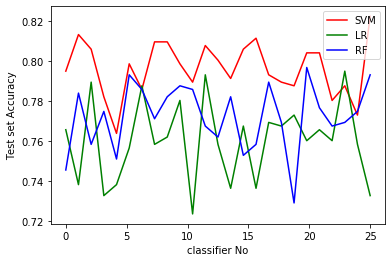

In [13]:
# Y_SVM, Y_LR, Y_RF: Accuracies of each iteration
t = np.linspace(0, NUM_OF_CLASSIFIERS, NUM_OF_CLASSIFIERS)
plt.plot(t, Y_SVM, 'r')
plt.plot(t, Y_LR, 'g')
plt.plot(t, Y_RF, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'LR', 'RF'))

plt.show()

In [14]:
print(np.max(Y_SVM), np.max(Y_RF), np.max(Y_LR))
print(np.mean(Y_SVM), np.mean(Y_RF), np.mean(Y_LR))

0.8223443223443223 0.7967032967032966 0.7948717948717948
0.7963369963369964 0.7722344322344321 0.7601465201465202


The best out of our iterations scores for each classifier is presented below

Needs Update!

Metric                | SVM        | Logistic Regression | Random Forest |
:----:                | :--------: | :-----------------: | :-----:       |
Training set Accuracy | 0.743      | 0.619               | 1             | 
Test set Accuracty    | 0.699      | 0.612               | 0.779         |

We clearly see that the Random Forest classifier with 100 trees outperfomrs the other 2, reaching 78% accuracy!

***

# Architecture #2
#### In this data architecture we will use as input the translation vector and rotation vector plus the 2 iris points) so a signle training example of our dataset will be of shape (10, 1). 
We already have the array X of shape (6, 1) containing the rotation and translation vectors stacked so we only need to extract the iris points from our data.json.

In [15]:
from PIL import Image
X2 = np.zeros((DATASET_SIZE, 10, 1))

# I add 4 values, the x1,y1,x2,y2 from the Iris coordinates
X2 = np.zeros((DATASET_SIZE, X.shape[1]+4, 1))

for i in trange(DATASET_SIZE):
    key = keys[i]
    im = Image.open('dataset/' + key)
    size = im.size

    iris_right = np.reshape(np.asarray(data_all[key]['iris_right']), (2, 1))/(np.array([[size[1]], [size[0]]]))
    iris_left = np.reshape(np.asarray(data_all[key]['iris_left']), (2, 1))/(np.array([[size[1]], [size[0]]]))
#     iris_right = np.reshape(np.asarray(data_all[key]['iris_right']), (2, 1))
#     iris_left = np.reshape(np.asarray(data_all[key]['iris_left']), (2, 1))
    X2[i, :] = np.concatenate((np.reshape(X[i, :], (X.shape[1], 1)), iris_left, iris_right), axis = 0)
print(X2.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2728/2728 [00:00<00:00, 4795.69it/s]

(2728, 146, 1)


In [16]:
X2 = X2.squeeze()
print(X2.shape)

(2728, 146)


The following steps are the same as for the first architecture

In [17]:
m = X2.mean(axis=0)
std = X2.std(axis=0)

X2_scaled = (X2-m)/std

# Train different classifiers
Here we will try out 3 classifiers and compare their results:
 - A SVM with rbf kernel and penalty parameter C=100
 - A Logistic Regression classifer
 - A Random Forest Classifier

In [18]:
# Number of classifiers to train in order to summarize the results
NUM_OF_CLASSIFIERS = 25
Y_SVM2, Y_LR2, Y_RF2 = np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS))

### SVM classifier

In [19]:
from sklearn import svm
for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
    
    svm_classifier2 = svm.SVC(C=100, kernel='rbf', gamma='scale')
    svm_classifier2.fit(X2_train, y2_train)
    y2_pred_svm = svm_classifier2.predict(X2_test)
    Y_SVM2[i] = metrics.accuracy_score(y2_test, y2_pred_svm)

print('Training set accuracy for SVM:', svm_classifier2.score(X2_train, y2_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y2_test, y2_pred_svm))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.06it/s]


Training set accuracy for SVM: 0.8547204399633364
Test set accuracy for SVM:  0.7985347985347986


### Logistic Regression Classifier

In [20]:
from sklearn.linear_model import LogisticRegression

for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
    
    lr_classifier2 = LogisticRegression(solver='lbfgs',)
    lr_classifier2.fit(X2_train, y2_train)
    y2_pred_lr = lr_classifier2.predict(X2_test)
    Y_LR2[i] = metrics.accuracy_score(y2_test, y2_pred_lr)

print('Training set accuracy for Logistic Regression:', lr_classifier2.score(X2_train, y2_train))
print('Test set accuracy for Logistic Regression: ', metrics.accuracy_score(y2_test, y2_pred_lr))

  0%|                                                                                                                                                                                                                | 0/25 [00:00<?, ?it/s]c:\users\ale\anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  4%|████████                                                                                                                                                                                                | 1/25 [00:00<00:02,  9.83it/s]c:\u

c:\users\ale\anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 14/25 [00:01<00:01, 10.25it/s]c:\users\ale\anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) 

Training set accuracy for Logistic Regression: 0.7593950504124656
Test set accuracy for Logistic Regression:  0.7967032967032966


### Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.2)
    
    rf_classifier2 = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier2.fit(X2_train, y2_train)
    y2_pred_rf = rf_classifier2.predict(X2_test)
    Y_RF2[i] = metrics.accuracy_score(y2_test, y2_pred_rf)

print('Training set accuracy for Random Forst:', rf_classifier2.score(X2_train, y2_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y2_test, y2_pred_rf))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:35<00:00,  1.43s/it]

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.7893772893772893


## Visualize & Summarize results for Architecture #2


We trained the 3 classifiers for 25 different train/test splits and the accuracy results are shown below

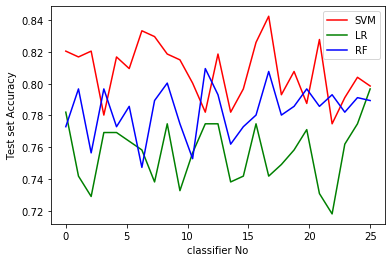

In [22]:
import matplotlib.pyplot as plt

t = np.linspace(0, NUM_OF_CLASSIFIERS, NUM_OF_CLASSIFIERS)
plt.plot(t, Y_SVM2, 'r')
plt.plot(t, Y_LR2, 'g')
plt.plot(t, Y_RF2, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'LR', 'RF'))

plt.show()

In [23]:
print(Y_SVM2.max(axis=0), Y_LR2.max(axis=0), Y_RF2.max(axis=0))
print(Y_SVM2.mean(axis=0), Y_LR2.mean(axis=0), Y_RF2.mean(axis=0))

0.8424908424908425 0.7967032967032966 0.8095238095238095
0.8077655677655678 0.7568498168498168 0.783003663003663


Metric                | SVM        | Logistic Regression | Random Forest |
:----:                | :--------: | :-----------------: | :-----:       |
Training set Accuracy | 0.752      | 0.533               | 1             | 
Test set Accuracty    | 0.716      | 0.588               | 0.770         |

The difference between the first and the second architecture is noticeable.
The SVM  method is more accurate now approaching the Random Forest accuracy, which also improved in but not as much as the SVM. Also, the Logistic Regression classifier seems unable to handle our Dataset in both architectures; therefore, we will not consider it for the next of our research. The best accuracy scored, 77%, is achieved by Random Forest classifier in our second data architecture.

***

# Architecture #3
In this archtecture we will use the difference vector between the iris and the inner edge point of the eye(Maybe add and image here?). First, we will keep the raw iris coordinates and add the 2 vectors to our training data, yielding to a shape of (14, 1). Afterwards we will try removing the absolute coordinates of the iris and compare the 2 results.

Previously on this notebook we had extracted the 68 facial landmarks as well as the two iris points. The 2 inner eye points are the landmarks 39 and 42

In [24]:
# Dataset construction

# I add 4 values, the x1,y1,x2,y2, but also the difference vector from Iris and the Eyes
X3 = np.zeros((DATASET_SIZE, X.shape[1]+8))

for i in trange(DATASET_SIZE):
    key = keys[i]
    
    landmarks = data_all[key]['landmarks']
    iris_right = np.asarray(data_all[key]['iris_right'])
    iris_left = np.asarray(data_all[key]['iris_left'])
    
    left_vector = np.asarray( (abs(iris_left[0] - landmarks[39]['x']), abs(iris_left[1] - landmarks[39]['y'])) )
    right_vector = np.asarray( (abs(iris_right[0] - landmarks[42]['x']), abs(iris_right[1] - landmarks[42]['y'])))
    X3[i] = np.concatenate((X2[i], left_vector, right_vector), axis=0)
    
#     if DEBUG:
#         im = cv2.imread('dataset/' + key)
#         cv2.circle(im, (int(iris_left[0]), int(iris_left[1])), 3, (0,0,255), -1)
#         cv2.circle(im, (int(iris_right[0]), int(iris_right[1])), 3, (0,0,255), -1)
#         cv2.circle(im, (landmarks[39]['x'], landmarks[39]['y']), 3, (0,0,255), -1)
#         cv2.circle(im, (landmarks[42]['x'], landmarks[42]['y']), 3, (0,0,255), -1)
#         cv2.imshow('Im', im)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

print(X3.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2728/2728 [00:00<00:00, 43658.99it/s]

(2728, 150)


In [25]:
print(X2[4].shape)
print(X3[1].shape)
print(left_vector)
print(X3.shape)

(146,)
(150,)
[13.94586025  5.40070248]
(2728, 150)


In [26]:
m = X3.mean(axis=0)
std = X3.std(axis=0)
X3_scaled = (X3-m)/std

print(m.shape)
print(std.shape)

(150,)
(150,)


In [27]:
# Number of classifiers to train in order to summarize the results
NUM_OF_CLASSIFIERS = 25
Y_SVM3, Y_LR3, Y_RF3 = np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS)), np.zeros((NUM_OF_CLASSIFIERS))

### SVM Classifier

In [28]:
from sklearn import svm

for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_scaled, y, test_size=0.2)
    
    svm_classifier3 = svm.SVC(C=400, kernel='rbf', gamma='scale')
    svm_classifier3.fit(X3_train, y3_train)
    y3_pred_svm = svm_classifier3.predict(X3_test)
    Y_SVM3[i] = metrics.accuracy_score(y3_test, y3_pred_svm)

# Print the last result
print('Training set accuracy for SVM:', svm_classifier3.score(X3_train, y3_train))
print('Test set accuracy for SVM: ', metrics.accuracy_score(y3_test, y3_pred_svm))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.21it/s]


Training set accuracy for SVM: 0.9376718606782768
Test set accuracy for SVM:  0.8717948717948718


### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

for i in trange(NUM_OF_CLASSIFIERS):
    # Try a different train/test split each time
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_scaled, y, test_size=0.2)
    
    rf_classifier3 = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier3.fit(X3_train, y3_train)
    y3_pred_rf = rf_classifier3.predict(X3_test)
    Y_RF3[i] = metrics.accuracy_score(y3_test, y3_pred_rf)

print('Training set accuracy for Random Forst:', rf_classifier3.score(X3_train, y3_train))
print('Test set accuracy for Random Forest: ', metrics.accuracy_score(y3_test, y3_pred_rf))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.32s/it]

Training set accuracy for Random Forst: 1.0
Test set accuracy for Random Forest:  0.836996336996337


### Visualize & Summarize results for Architecture #3

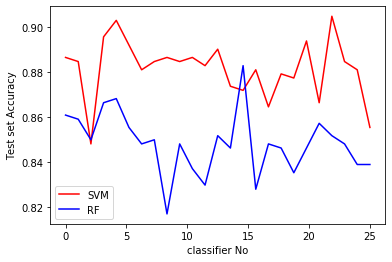

In [189]:
import matplotlib.pyplot as plt

t = np.linspace(0, NUM_OF_CLASSIFIERS, NUM_OF_CLASSIFIERS)
plt.plot(t, Y_SVM3, 'r')
plt.plot(t, Y_RF3, 'b')
plt.xlabel('classifier No')
plt.ylabel('Test set Accuracy')
plt.legend(('SVM', 'RF'))

plt.show()

In [190]:
print(Y_SVM3.max(axis=0), Y_RF3.max(axis=0))
print(Y_SVM3.mean(axis=0), Y_RF3.mean(axis=0))

0.9047619047619048 0.8827838827838828
0.8815384615384615 0.8482783882783883


In [191]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/ale/.virtualenvs/Predictive/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


<module 'matplotlib.pyplot' from '/Users/ale/.virtualenvs/Predictive/lib/python3.7/site-packages/matplotlib/pyplot.py'>

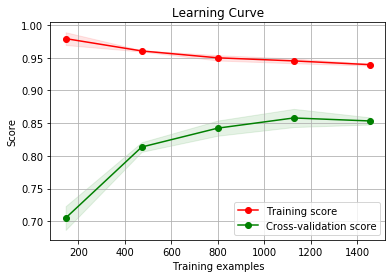

In [192]:
plot_learning_curve(svm_classifier3, 'Learning Curve', X3_train, y3_train)

# This is only for the last split of the SVM classifier

At this point we also tried feeding the difference vectors only without the absolute iris location, reaching an overall accuracy 2% lower than the one above.